# IMPORT SECTION

In [ ]:
!pip install --upgrade music21
from music21 import converter, instrument, note, chord
import os
from tqdm import tqdm
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
%load_ext tensorboard 
from tensorboard import notebook
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Bidirectional, Input, Layer, Dense, Reshape, concatenate
from keras.models import Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

     |████████████████████████████████| 19.3MB 53.5MB/s 
  Created wheel for music21: filename=music21-6.7.1-cp37-none-any.whl size=21941694 sha256=63acd482fb1913d6f67dbb92d1f6f8e9ee9e2b0f0932a45d61c9d42070f60951
  Stored in directory: /root/.cache/pip/wheels/1a/0f/0e/f78ad56a2738f4ea5082dd4283d7b7cce18a8ba20c3e609b6c
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=False)

MIDI_PATH="/content/drive/My Drive/MLFolder/Onlab/MIDI_Iron_Maiden/"

Mounted at /content/drive


In [ ]:
!cat /proc/cpuinfo

In [ ]:
!nvidia-smi

Fri Apr 16 12:28:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# UTILITY FUNCTIONS SECTION

In [ ]:
#https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

def most_frequent(paramlist): 
    counter = 0
    num = paramlist[0] 
      
    for i in paramlist: 
        curr_frequency = paramlist.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

#Utility functions

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def create_mapper(chords):
    pitchnames = sorted(set(str(item) for item in chords))
    mapper = dict((note, number) for number, note in enumerate(pitchnames))

    return mapper

def encode_using_mapper(chords, mapper):
    encodedsong=[]
    for c in chords:
        encodedsong.append(mapper[str(c)])

    return encodedsong


def decode_chords_using_mapper(numbers, mapper):
    outputnotes = []
    for number in numbers:
        outputnotes.append(chord_from_string(get_notes_from_chord(get_key_from_value(number, mapper))))

    return outputnotes

def combine_chords_with_durations(chords, durations):
    combined = []

    for i, j in zip(chords, durations):
        i = get_notes_from_chord(str(i))
        j = get_number_from_duration(str(j))
        combined.append(i + ';' + j)

    return combined

def make_slices(data, slice_length):
    for song in tqdm(data):
        if len(song) > slice_length:

            input = []
            output = []
            slice = []

            for idx, number in enumerate(song):
                if idx < slice_length:
                    slice.append(number)

            input.append(slice.copy())
            output.append(song[slice_length])

            # Sliding window
            for idx, number in enumerate(song):
                if idx >= slice_length and (idx + 1) < len(song):
                    slice.pop(0)
                    slice.append(number)
                    input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
                    output.append(song[idx + 1])

    return input, output

def parse_everything_together(data, slice_length):

    notes=[]
    input=[]
    output=[]
    slice = []

    for song in tqdm(data):
        for number in song:
            notes.append(number)
    
    for idx, note in tqdm(enumerate(notes)):
        if idx < slice_length:
            slice.append(number)

    input.append(slice.copy())
    output.append(notes[slice_length])

    # Sliding window
    for idx, number in tqdm(enumerate(notes)):
        if idx >= slice_length and (idx + 1) < len(notes):
            slice.pop(0)
            slice.append(number)
            input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
            output.append(notes[idx + 1])
        
    return input, output

def get_key_from_value(value, dict):
    return list(dict.keys())[list(dict.values()).index(value)]

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def chord_from_string(chordstring):
    notes = chordstring.split(";")
    return chord.Chord(notes)

#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

#Source: https://github.com/alexissa32/DataScienceMusic
def create_midi_without_chords(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    First step:
    Only notes, no chords
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_without_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    Second step:
    Chords and notes
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_durations(prediction_output, output_durations, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        duration = get_number_from_duration(output_durations[i])
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_embedded_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        splitpattern = pattern.split(";")
        pattern = splitpattern[0]

        duration = get_number_from_duration(splitpattern[1])
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a chord
        elif (',' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def parse_midi_notes_and_durations():
    midiparts = []

    for file in tqdm(os.listdir(path)):
        midi = converter.parse(os.path.join(path, file))

        for part in midi.parts:
            chords=[]
            durations=[]
            for element in part.notesAndRests:
                if isinstance(element, note.Note):
                    chords.append(chord.Chord([element]))
                    durations.append(element.duration)
                elif isinstance(element, chord.Chord):
                    chords.append(element)
                    durations.append(element.duration)
                elif isinstance(element, note.Rest):
                    chords.append(element)
                    durations.append(element.duration)

            if len(chords) > 0:
                midiparts.append(MidiPart(file, part.partName, chords, durations))
            else:
                for voice in part.voices:
                    chords=[]
                    durations=[]
                    for element in voice.notesAndRests:
                        if isinstance(element, note.Note):
                            chords.append(chord.Chord([element]))
                            durations.append(element.duration)
                        elif isinstance(element, chord.Chord):
                            chords.append(element)
                            durations.append(element.duration)
                        elif isinstance(element, note.Rest):
                            chords.append(element)
                            durations.append(element.duration)

                    midiparts.append(MidiPart(file, part.partName, chords, durations))

    return midiparts

# PREPROCESSING SECTION

In [ ]:
class MidiPart:
    def __init__(self, song, instrument, chords, durations):
        self.song = song
        self.instrument = instrument
        self.chords = chords
        self.durations = durations


path = MIDI_PATH

IRON_MAIDEN_INSTRUMENTS = ['Acoustic Guitar', 'Viola', 'Electric Bass', 'Brass', 'Sampler', 'Electric Guitar', 'Piano', 'StringInstrument']

#TARGET_INSTRUMENT = 'Electric Bass'

SLICE_LEN = 16

In [ ]:
midiparts = parse_midi_notes_and_durations()

100%|██████████| 93/93 [14:19<00:00,  9.24s/it]


In [ ]:
allchords = []
alldurations = []

TARGET_INSTRUMENT = 'Electric Bass'
for i in midiparts:
    if i.instrument == TARGET_INSTRUMENT:
        if len(i.chords)>0 :
            allchords.append(i.chords)
            alldurations.append(i.durations)

In [ ]:
mapperdata = []

for i in allchords:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)


encoded_data = []

for c in allchords:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)


restnumber = mapper['<music21.note.Rest rest>']

cleared_encoded_data=[]

for i in encoded_data:
    if most_frequent(i) != restnumber:
        cleared_encoded_data.append(i)
    else:
        pass




In [ ]:
assert(len(allchords) == len(alldurations))

combined = []
for i in range(len(allchords)):
    combined.append(combine_chords_with_durations(allchords[i], alldurations[i]))

mapperdata = []

for i in combined:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)


encoded_data = []

for c in combined:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)


restkeysvalues = []
for j in mapper.keys():
    if ( 'rest' in j):
        restkeysvalues.append(mapper[j])

cleared_encoded_data=[]

for i in range(len(encoded_data)):
    if most_frequent(encoded_data[i]) not in restkeysvalues:
        cleared_encoded_data.append(encoded_data[i])
    else:
        pass

In [ ]:
#input, output = parse_everything_together(cleared_encoded_data, SLICE_LEN)

100%|██████████| 103/103 [00:00<00:00, 8300.13it/s]
159664it [00:00, 2508209.34it/s]
159664it [00:00, 504779.12it/s]


In [ ]:
cleared_encoded_data_full = []

for i in cleared_encoded_data:
    for j in i:
        cleared_encoded_data_full.append(j)

cleared_encoded_data_full = np.asarray(cleared_encoded_data_full)

In [ ]:
input = cleared_encoded_data_full
output = cleared_encoded_data_full

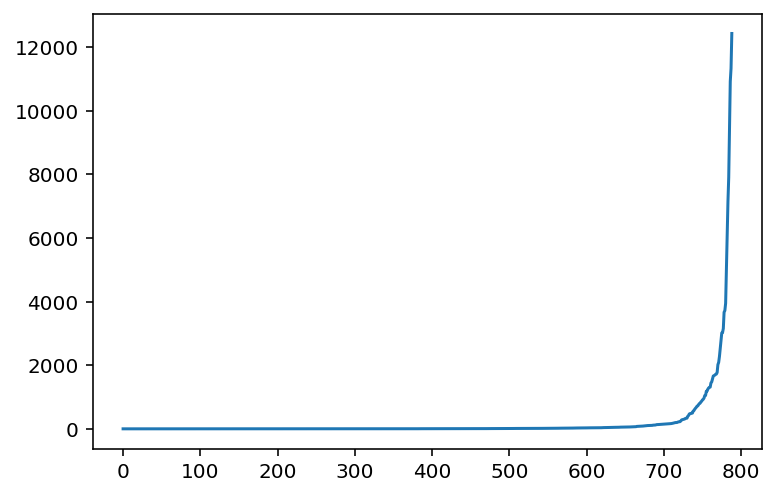

[282, 50, 134, 281, 590, 709, 151, 717, 799, 154, 142, 492, 301, 222, 220, 647, 490, 214, 491, 299, 375, 644, 502, 728, 676, 425, 607, 244, 283, 428, 342, 245, 340, 597, 333, 457, 429, 611, 598, 343, 430, 614, 53, 156, 23, 26, 711, 254, 359, 276, 737, 288, 74, 79, 205, 49, 64, 56, 688, 194, 195, 695, 478, 335, 697, 481, 814, 171, 468, 175, 817, 586, 508, 589, 35, 448, 192, 331, 408, 187, 318, 182, 414, 580, 763, 422, 66, 605, 600, 86, 101, 368, 783, 58, 546, 305, 304, 94, 379, 215, 302, 376, 795, 552, 558, 556, 52, 291, 386, 392, 384, 391, 338, 332, 230, 122, 764, 390, 383, 289, 292, 177, 172, 173, 683, 157, 625, 790, 316, 587, 170, 511, 621, 362, 585, 500, 557, 604, 218, 229, 403, 317, 325, 115, 713, 190, 324, 106, 186, 705, 204, 357, 45, 452, 532, 673, 672, 447, 446, 235, 236, 451, 453, 454, 124, 126, 127, 531, 533, 534, 765, 767, 768, 545, 18, 237, 460, 128, 459, 655, 280, 279, 278, 583, 507, 576, 256, 632, 158, 360, 261, 732, 193, 141, 4, 117, 782, 704, 781, 105, 690, 13, 619, 320,

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

outputcnt = Counter(cleared_encoded_data_full)
#plt.bar(outputcnt.keys(), outputcnt.values())
#plt.show()

function_like_array=[]
for val in outputcnt.values():
    function_like_array.append(val)

function_like_array.sort()
plt.plot(function_like_array)
plt.show()

outliers = []

for i in outputcnt.keys():
    if outputcnt[i] < 80:
        outliers.append(i)

print(outliers)
print(len(outliers))

In [ ]:
#Because I don't want to mess up my inputs and outputs, I test their lengths before and after the outlier filtering.
#assert(len(input) == len(output))

newinput=[]

for i in range(len(cleared_encoded_data_full)):
    if(cleared_encoded_data_full[i] not in outliers):
        newinput.append(cleared_encoded_data_full[i])

input = newinput
#output = newinput

#assert(len(input) == len(output))

In [ ]:
#However, this outlier filtering made things complicated. Now I have to make a new mapper, so that i won't end up with output classes containing 0 elements.

mapper_list = [] #Idx of the mapper list is the new value, the element is the old value.
new_input_elements = set(input)

for i in new_input_elements:
    mapper_list.append(i)

newinput = []

for i in input:
    newinput.append(mapper_list.index(i))

input = newinput
output = newinput

In [ ]:
#Reshaping the input data to be compatible with LSTMs and normalizing it in the hope of better learning.

#input = np.reshape(np.asarray(input), (len(input), SLICE_LEN, 1))
#output = to_categorical(output)

#input=np.asarray(input) / float(len(mapper))
input = np.asarray(input)
output = np.asarray(output)

In [ ]:
SEED = 54
#np.random.seed(SEED)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.01, random_state=SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=SEED)

#startidx = np.random.randint(0, len(X_test)-1)
#starting_slice = X_test[startidx]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
#print(startidx)
#print(starting_slice)

(126453,) (31614,) (1597,) (126453,) (31614,) (1597,)


In [ ]:
NUM_CLASSES = np.max(input)+1
print(NUM_CLASSES)

134


# MODEL UTILS SECTION

In [ ]:
from keras.utils import Sequence

# DATA GENERATOR

SLICE_SIZE = SLICE_LEN

class MyDatagen(Sequence):
  def __init__(self, list_IDs, batch_size=16, dim=(SLICE_SIZE), shuffle=True, validation=False):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.list_IDs = list_IDs
    self.shuffle = shuffle
    self.validation=validation
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
      #Updates indexes after each epoch
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    #Generates data containing batch_size samples
    if self.validation:
      X = np.empty((self.batch_size, self.dim, 1))
      y = np.empty((self.batch_size, self.dim, NUM_CLASSES))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = np.expand_dims(X_val[ID:ID+self.dim]/(NUM_CLASSES-1), axis=1)

        y[i] = to_categorical(X_val[ID:ID+self.dim], num_classes=NUM_CLASSES)

      return X, y
    else:
      X = np.empty((self.batch_size, self.dim, 1))
      y = np.empty((self.batch_size, self.dim, NUM_CLASSES))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = np.expand_dims(X_train[ID:ID+self.dim]/(NUM_CLASSES-1), axis=1)

        y[i] = to_categorical(X_train[ID:ID+self.dim], num_classes=NUM_CLASSES)

      return X, y

In [ ]:
MODEL_NAME = "VAE6"

MODEL_SAVE_PATH = "/content/drive/MyDrive/MLFolder/Onlab/modelsaves/"

TBPATH = "/content/tblogs/"+MODEL_NAME

In [ ]:
#Before creating the neural network, I define some important callbacks

tb = TensorBoard(log_dir = TBPATH, write_images=True, histogram_freq=1)

plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005, verbose=1)

es = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True, verbose=1)

callbacks = [plateau, es, tb]

In [ ]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
from keras.layers import Concatenate
from keras.layers import Add

def make_decoder_block(parent_conductor, initial_decoder, LSTM_cells, block_size, previous_output = None):
    first_layer = []
    first_layer.append(initial_decoder)

    for i in range(1, block_size):
        first_layer.append(LSTM(LSTM_cells, return_sequences=True)(Add()([parent_conductor, first_layer[i-1]])))

    second_layer = []

    for i in first_layer:
        second_layer.append(LSTM(LSTM_cells)(i))

    outputs = []
    
    for i in range(len(second_layer)):
        if i == 0:
            if previous_output is None:    #First of the first block
                outputs.append(Dense(NUM_CLASSES, activation="softmax")(second_layer[i]))
            else:      #First of all other blocks
                concatted_output = Concatenate()([second_layer[i], previous_output])
                outputs.append(Dense(NUM_CLASSES, activation="softmax")(concatted_output))
        else:   #The rest
            concatted_output = Concatenate()([second_layer[i], outputs[i-1]])
            outputs.append(Dense(NUM_CLASSES, activation="softmax")(concatted_output))

            

    return outputs

# MODEL BUILDING AND TRAINING SECTION

In [ ]:
from keras.models import Sequential
from keras.layers import Concatenate

LSTM_STATES = 2048
ENCODER_LSTM_CELLS = 128
latent_dim = 256
LSTM_cells = 64

notes_input = Input(shape=(SLICE_LEN, 1), name="notes_in")
x1 = Bidirectional(LSTM(ENCODER_LSTM_CELLS))(notes_input)
x2 = Bidirectional(LSTM(ENCODER_LSTM_CELLS))(notes_input)
x = Concatenate()([x1, x2])
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var", activation='softplus')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(notes_input, z, name="encoder")

#encoder.summary()

decoder_input = Input(shape=(latent_dim), name="decoder_in")
y = Dense(LSTM_cells, activation='tanh')(decoder_input)
y = Reshape((LSTM_cells, 1))(y)

conductor = LSTM(LSTM_cells, return_sequences=True)(y)
conductors = []
conductors.append(conductor)

for i in range(1, 4):
    conductors.append(LSTM(LSTM_cells, return_sequences=True)(conductors[i-1]))

initial_decoders = []

for i in conductors:
    initial_decoders.append(LSTM(LSTM_cells, return_sequences=True)(i))

final_outputs = []
output_per_decoder_block = 4

for i in range(len(initial_decoders)):
    if i == 0:
        decoder_block = make_decoder_block(conductors[i], initial_decoders[i], 64, output_per_decoder_block)
        for j in decoder_block:
            final_outputs.append(j)
    else:
        decoder_block = make_decoder_block(conductors[i], initial_decoders[i], 64, output_per_decoder_block, final_outputs[i*output_per_decoder_block-1])
        for j in decoder_block:
            final_outputs.append(j)

#print(final_outputs[0])

out = concatenate(final_outputs, axis=1)
out = Reshape((SLICE_LEN, NUM_CLASSES))(out)

decoder = Model(decoder_input, out, name="decoder")

VAE = Sequential()
VAE.add(encoder)
VAE.add(decoder)

#VAE = Model(notes_input, out)

#VAE.summary()


In [ ]:
VAE.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
training_gen=MyDatagen(range(X_train.shape[0]-SLICE_LEN), batch_size=16)
val_gen=MyDatagen(range(X_val.shape[0]-SLICE_LEN), batch_size=16, validation=True)
#val_gen=MyDatagen(range(TRAIN_SAMPLES, TRAIN_SAMPLES+VAL_SAMPLES), validation=True)

VAE.fit(x=training_gen, validation_data=val_gen, epochs=100)

Epoch 1/100
1930/7902 [======>.......................] - ETA: 11:48 - loss: 3.0899 - accuracy: 0.1620

In [ ]:
VAE.save(MODEL_SAVE_PATH+MODEL_NAME)

# INFERENCE SECTION

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    preds = np.squeeze(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
from music21 import stream
from music21.stream import Score

STARTING_OFFSET = 0
OUTPUT_PATH = "/content/drive/MyDrive/MLFolder/Onlab/Outputs/"

def prediction_function(mapperlist = None, resample = True):

    plot_noise = False
    GENERATED_SLICES = 10
    temperatures = [0.5, 0.7, 0.8, 1.0]

    for temp in temperatures:
        for i in range(GENERATED_SLICES):
            noise = np.random.normal(size=latent_dim)
            if plot_noise:
                plt.plot(noise)
                plt.show()
            noise = np.expand_dims(noise, 0)
            pred = decoder.predict(noise)
            predicted = []
            for j in pred:
                for k in j:
                    if resample:
                        index = sample(k, temp)
                        if mapperlist is not None: #Idx of the mapper list is the new value, the element is the old value. This is used when I filter for outliers.
                            index=mapperlist[index]
                        pred_note = get_key_from_value(index, mapper)
                        predicted.append(pred_note)
                    else:
                        index = np.argmax(k)
                        if mapperlist is not None:
                            index=mapperlist[index]
                        pred_note = get_key_from_value(index, mapper)
                        predicted.append(pred_note)
            #create_midi_with_embedded_durations(predicted, target_instrument = instrument.ElectricGuitar(), filename = OUTPUT_PATH + MODEL_NAME + f'{i+STARTING_OFFSET}guitartemp={temp}.mid')
            print(predicted)
    

In [ ]:
prediction_function(resample=True)

['<music21.chord.Chord B1>', '<music21.chord.Chord C2>', '<music21.chord.Chord E2>', '<music21.chord.Chord D2>', '<music21.chord.Chord E1>', '<music21.chord.Chord G1>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord A1>', '<music21.chord.Chord D2>', '<music21.chord.Chord D2>', '<music21.chord.Chord E2>', '<music21.chord.Chord A1>', '<music21.chord.Chord C2>', '<music21.chord.Chord D2>', '<music21.chord.Chord D2>']
['<music21.chord.Chord D2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord D2>', '<music21.chord.Chord B1>', '<music21.chord.Chord G1>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord A2>', '<music21.chord.Chord D2>', '<music21.chord.Chord C2>', '<music21.chord.Chord C2>', '<music21.chord.Chord E2>', '<music21.chord.Chord D2>', '<music21.chord.Chord E2>', '<music21.chord.Chord D2>']
['<music21.chord.Chord D2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.C

# DEBUG SECTION

In [ ]:
SLICE_LEN = 64

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes = True)

In [ ]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_in (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 64)           16448       decoder_in[0][0]                 
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 64, 1)        0           dense_17[0][0]                   
__________________________________________________________________________________________________
lstm_40 (LSTM)                  (None, 64, 64)       16896       reshape_2[0][0]                  
____________________________________________________________________________________________

In [ ]:
print(cleared_encoded_data_full.shape)
print(np.max(cleared_encoded_data_full))

(159664,)
133


In [ ]:
import tensorflow as tf
from keras.losses import categorical_crossentropy

class MyModel(Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def __call__(self, input):
        return self.call(input, training=False)

    def train_step(self, data):
        #x, y = data

        with tf.GradientTape() as tape:
            z = self.encoder(data[0])

            reconstruction = self.decoder(z)

            loss = tf.reduce_mean(
                tf.reduce_sum(
                    categorical_crossentropy(data[0], reconstruction)
                )
            )

            #print(f'Shape of x:{x.shape}')

            #print(f'Shape of y:{y.shape}')

            #y_pred = self(x, training=True)

            #print(f'Shape of  y_pred:{y_pred.shape}')

            #print(f'Shape of  y_pred[0]:{y_pred[0].shape}')

            #tf.print(y_pred)

            #loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            self.compiled_metrics.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
import gc
gc.collect()

3065790